In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [10]:
img_ori=cv2.imread('test2.jpg')
height,width,channel=img_ori.shape
print(height,width,channel)
#이미지의 크기를 oepncv를 통해서 자동으로 지정해줌

403 452 3


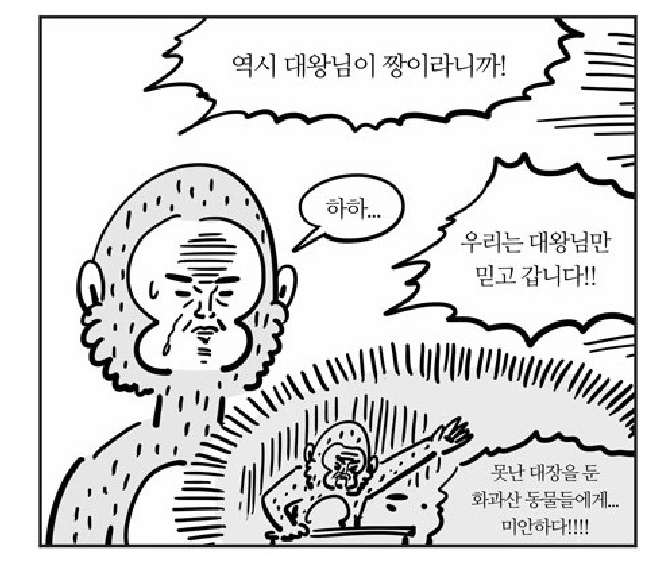

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap='gray')

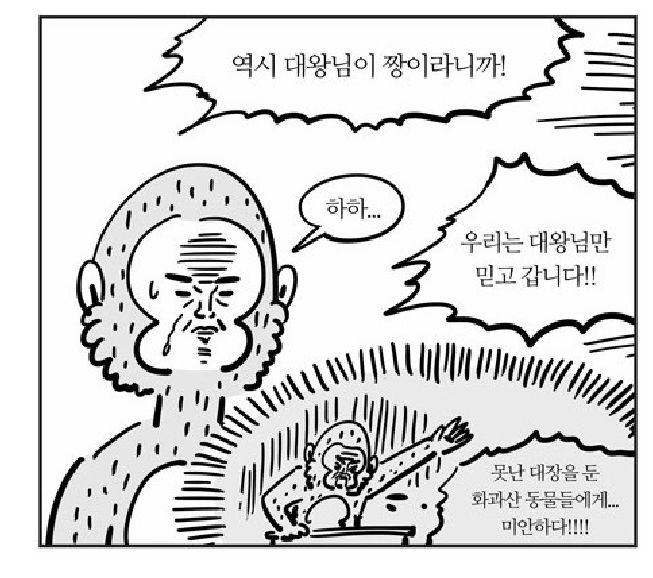

In [12]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
#단색으로 하는편이 이미지판별하기 쉬우므로 그레이스케일로 바꿔줌

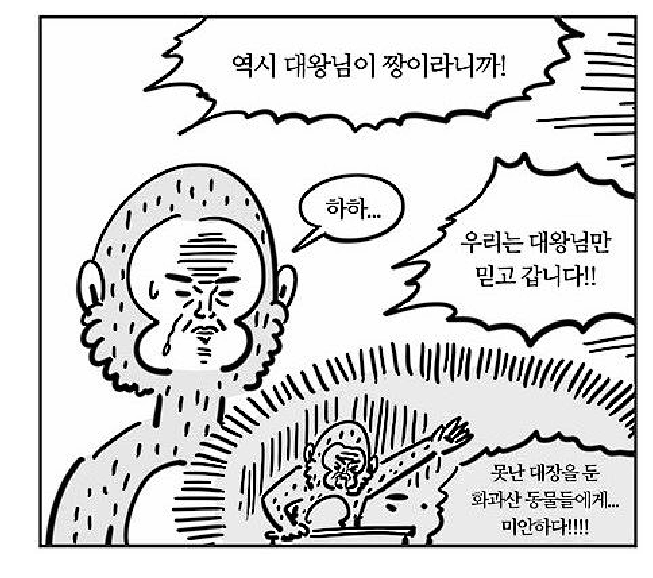

In [13]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

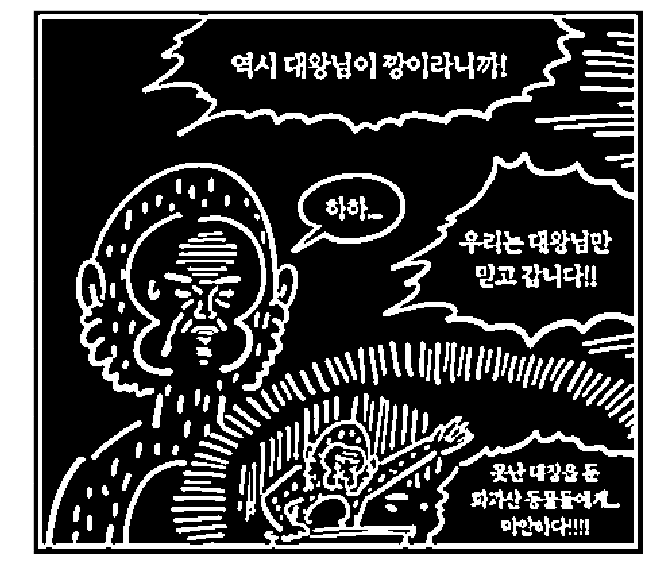

In [14]:

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
#이미지의 노이즈를 줄이기 위해서 사용

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)#쓰레쉬홀더는 평균값을 지정해줘서 이미지를 구별하기쉽게 0,1 이런식으로 해줌 (흑백으로 나눠줌)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

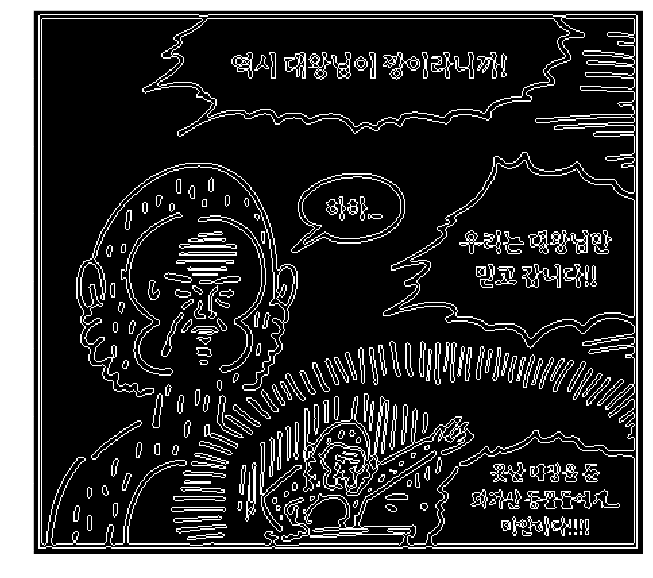

In [15]:
#findcountours 반환값 3개에서 2개로 바뀜(기존 image, contours, hierachy->contours, hierachy)
#https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539/
contours,_= cv2.findContours(
    img_thresh,
    mode=cv2.RETR_TREE,
    method=cv2.CHAIN_APPROX_NONE
) 
#
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

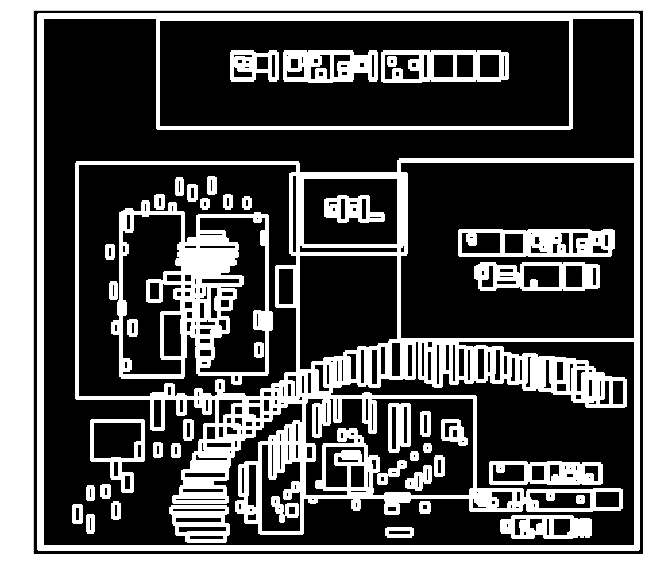

In [16]:
#번호판 위치를 찾는 과정
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []
#윤각선에서 번호판의 위치를 찾는다


for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)#contours의 사각형 범위를 찾는함수
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    #바인딩 렉터를 그려보는함수
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2), #중심좌표 저장
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

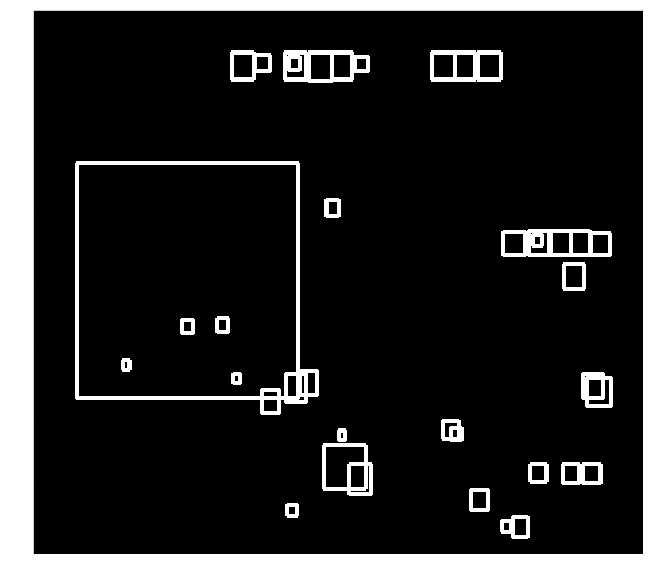

In [17]:
MIN_AREA = 30 #윤각성의 최소넓이
MIN_WIDTH, MIN_HEIGHT = 0.1, 5 #최소너비와 높이
MIN_RATIO, MAX_RATIO = 0.7, 1.0 #가로대비 세로비율
#글자의 크기를 대략적으로 지정하여서 번호판을 찾는과정

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
    #인덱스로 지정해서 찾아들어가기
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [ ]:
MAX_DIAG_MULTIPLYER = 5 # 5 #퀀터와 퀀터사이의 거리 5배안에있어야함
MIN_DIAG_MULTIPLYER = 0.1
MAX_ANGLE_DIFF = 12.0 # 12.0 #퀀터사이의 각도의 최소값 12도안에있어야함
MAX_AREA_DIFF = 0.5 # 0.5 #퀀터간의 면적차이
MAX_WIDTH_DIFF = 0.7 #퀀터간의 너비 차이
MAX_HEIGHT_DIFF = 0.2 #퀀터간의 높이
MIN_N_MATCHED = 3 # 3 #조건이 3개이상이되야 인정

#위치의 배열을 찾아서 번호판의 위치를 추측

def find_chars(contour_list):
    #재귀함수로서 계속해서 찾아감
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            #np.linalg.norm(a-b) 벡터 a와 벡터 b사이의 거리를 구한다
            if dx == 0: #0이나오면 그냥 90도로 만들어서 패스시킴
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
                #아크 탄젠트의 값을 구해서 각도측정
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER and distance > diagonal_length1 * MIN_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx']) #d2만 순차적으로 넣어줌

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        #최종후보군이 아닌애들도 일단은 한번 비교해봄
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        #a에서 idx와 같은 인덱스의 값만 추출
        
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        #다시 처음부터 돌려서 확인
        
#         for idx in recursive_contour_list:
#             matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')